# SAM / SAM‑HQ Batch Inference
This notebook runs Segment‑Anything (SAM) or SAM‑HQ on a folder of images and saves the masks, blends, and probability maps.


## 1. Imports

In [3]:
#!conda env create -f sam.yml # Run this line once and the comment out
!conda init
!conda activate sam

no change     /opt/tljh/user/condabin/conda
no change     /opt/tljh/user/bin/conda
no change     /opt/tljh/user/bin/conda-env
no change     /opt/tljh/user/bin/activate
no change     /opt/tljh/user/bin/deactivate
no change     /opt/tljh/user/etc/profile.d/conda.sh
no change     /opt/tljh/user/etc/fish/conf.d/conda.fish
no change     /opt/tljh/user/shell/condabin/Conda.psm1
no change     /opt/tljh/user/shell/condabin/conda-hook.ps1
no change     /opt/tljh/user/lib/python3.10/site-packages/xontrib/conda.xsh
no change     /opt/tljh/user/etc/profile.d/conda.csh
no change     /home/jupyter-dai7591/.bashrc
No action taken.

CondaError: Run 'conda init' before 'conda activate'



In [12]:
import os
import torch
from SAM.segment_anything import sam_model_registry, get_sam_label
from PIL import Image
from tqdm import tqdm
import numpy as np

## 2. Helper functions

In [13]:
@torch.no_grad()
def get_sam_info(image,
                 box_nms=0.7,
                 min_mask_region_area=100,
                 pred_iou_thresh=0.88,
                 stability_score_thresh=0.92):
    """Run SAM/SAM‑HQ on a single image and return (label, blend, label_P)."""
    with torch.autocast(device_type='cuda', dtype=torch.float16):
        label, blend, label_P = get_sam_label(
            sam, image,
            box_nms=box_nms,
            min_mask_region_area=min_mask_region_area,
            pred_iou_thresh=pred_iou_thresh,
            stability_score_thresh=stability_score_thresh
        )
    return label, blend, label_P


def process_data_img(image_dir, img_name):
    """Run inference on *img_name* and write outputs to disk."""
    png_name = os.path.splitext(img_name)[0] + '.png'
    img      = Image.open(os.path.join(image_dir, img_name))

    label, blend, label_P = get_sam_info(
        img,
        box_nms=box_nms,
        min_mask_region_area=min_region,
        pred_iou_thresh=pred_iou_thresh,
        stability_score_thresh=stability_score_thresh,
    )

    label.save(os.path.join(lbl_dir,  png_name))
    blend.save(os.path.join(bld_dir,  png_name))
    np.save(os.path.join(lblp_dir, png_name.replace('.png', '.npy')), label_P)

def process_data_json(image_file,img_name):

    img = Image.open(os.path.join(image_file,img_name))
    sam_info = get_sam_info(img,box_nms=box_nms,min_mask_region_area =min_region,pred_iou_thresh=pred_iou_thresh,stability_score_thresh=stability_score_thresh)
    json_data = json.dumps(sam_info, indent=4, ensure_ascii=False)  

    with open(os.path.join(sam_json_dir, img_name.split('.')[0]+'.json'),'w') as f:  
        f.write(json_data)
        
def make_dirs():
    """Create output directories if they don't exist."""
    for d in (sam_img_dir, lbl_dir, bld_dir, lblp_dir, sam_json_dir):
        os.makedirs(d, exist_ok=True)

## 3. Parameters
Feel free to tweak these before running the next cell.

In [26]:
# ─── Inference hyper‑parameters for SAM HQ ───────────────────────────
min_region             = 500
box_nms                = 0.6
pred_iou_thresh        = 0.85
stability_score_thresh = 0.85

# ─── Model Options ───────────────────────────
    
'''
"vit_h": build_sam_vit_h,
"vit_tiny": build_sam_vit_t
'''

# ─── Checkpoint ───────────────────────────────────────────
model_type = 'vit_h'

# ─── Paths ────────────────────────────────────────────────
image_dir = 'GeoSeg/data/Urban/val/images'

if model_type == 'vit_tiny':
    sam_img_dir = 'GeoSeg/fig_results/Urban/output_masks_loveda/sam_label/sam_t'
    sam_json_dir = 'GeoSeg/fig_results/Urban/output_masks_loveda/sam_label/sam_t'
    sam_checkpoint = {'vit_tiny': "SAM/ckpt/sam_hq_vit_tiny.pth"} 
if model_type == 'vit_h':
    sam_img_dir = 'GeoSeg/fig_results/Urban/output_masks_loveda/sam_label/sam_hq'
    sam_json_dir = 'GeoSeg/fig_results/Urban/output_masks_loveda/sam_label/sam_hq'
    sam_checkpoint = {'vit_h': "SAM/ckpt/sam_hq_vit_h.pth"} 


lbl_dir  = os.path.join(sam_img_dir, "label")
bld_dir  = os.path.join(sam_img_dir, "blend")
lblp_dir = os.path.join(sam_img_dir, "label_p")

## 4. Load SAM model

In [27]:
device = "cuda" if torch.cuda.is_available() else "cpu"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint[model_type])
sam.to(device)
sam.eval()
print("Model loaded on", device)

<All keys matched successfully>
Model loaded on cuda


## 5. Gen SAM masks inference

In [ ]:
make_dirs()

val_lines = os.listdir(image_dir)
for fname in tqdm(val_lines, desc="Processing"):
    process_data_img(image_dir, fname)

Processing:   0%|          | 0/677 [00:00<?, ?it/s]

## 6. Gen SAM json

In [23]:
os.makedirs(sam_json_dir,exist_ok=True)

val_lines = os.listdir(image_dir)
for val_line in tqdm(val_lines):
    process_data_json(image_dir, val_line)

  0%|          | 0/677 [00:02<?, ?it/s]


KeyboardInterrupt: 

## Visualize results

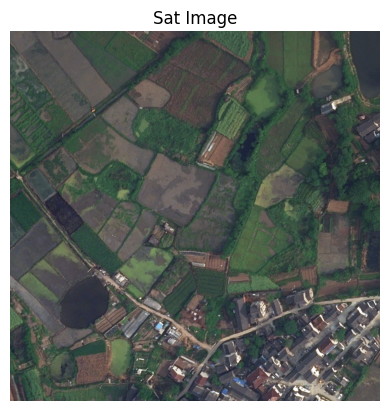

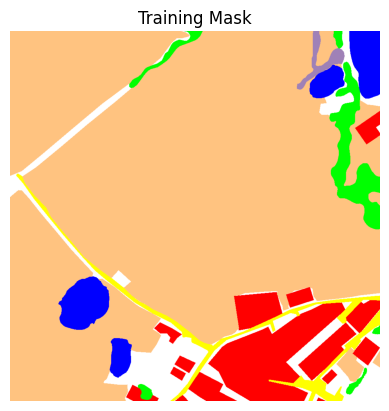

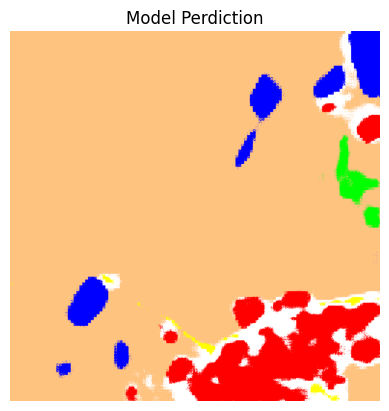

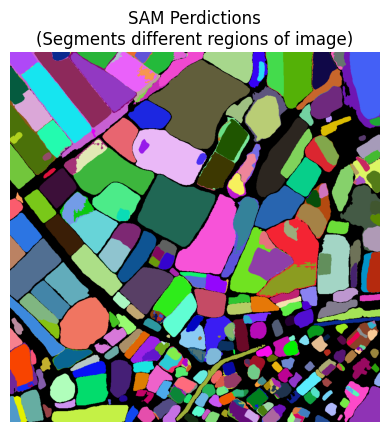

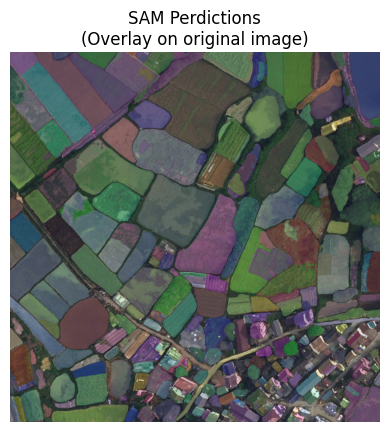

In [29]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img_id = 3553
mask_id = img_id

sat_image = f"GeoSeg/data/Urban/val/images/{img_id}.png"  
img = mpimg.imread(sat_image)
plt.imshow(img)
plt.axis('off') 
plt.title("Sat Image") 
plt.show()

mask = f"GeoSeg/data/Urban/val/masks/{img_id}.png"  
img = mpimg.imread(mask)
plt.imshow(img)
plt.axis('off') 
plt.title("Training Mask") 
plt.show()

model_perdict = f"GeoSeg/fig_results/Urban/output_masks_loveda/pre_rgb/{mask_id}.png"  
img = mpimg.imread(model_perdict)
plt.imshow(img)
plt.axis('off') 
plt.title("Model Perdiction") 
plt.show()

model_perdict = f"GeoSeg/fig_results/Urban/output_masks_loveda/sam_label/sam_hq/label/{mask_id}.png"  
img = mpimg.imread(model_perdict)
plt.imshow(img)
plt.axis('off') 
plt.title("SAM Perdictions\n(Segments different regions of image)") 
plt.show()

model_perdict = f"GeoSeg/fig_results/Urban/output_masks_loveda/sam_label/sam_hq/blend/{mask_id}.png"  
img = mpimg.imread(model_perdict)
plt.imshow(img)
plt.axis('off') 
plt.title("SAM Perdictions\n(Overlay on original image)") 
plt.show()